In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import string
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
stem = PorterStemmer()
stopwords = stopwords.words('english')

In [7]:
df = pd.read_csv(r'Phishing_Email.csv')

In [8]:
df.drop('Unnamed: 0', axis =1, inplace = True)

In [9]:
df.isna().sum()

Email Text    16
Email Type     0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.duplicated().sum()

1096

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
(df['Email Type'].value_counts()/len(df))*100

Safe Email        62.606911
Phishing Email    37.393089
Name: Email Type, dtype: float64

In [14]:
df.shape

(17538, 2)

In [15]:
df.rename(columns = ({'Email Text':'email_text','Email Type':'email_type'}),inplace=True)

In [16]:
def Cleaning(x):
    y = []
    x = x.lower()
    for i in x.split():
        if i.isalnum() and i not in string.punctuation:
            y.append(i)
    x = y[:]
    y.clear()

    for i in x:
        y.append(stem.stem(i))
    x = y[:]
    y.clear()

    for i in x:
        if i not in stopwords:
            y.append(i)
    return " ".join(y)       

In [17]:
df['cleaned_text'] = df.email_text.apply(Cleaning)

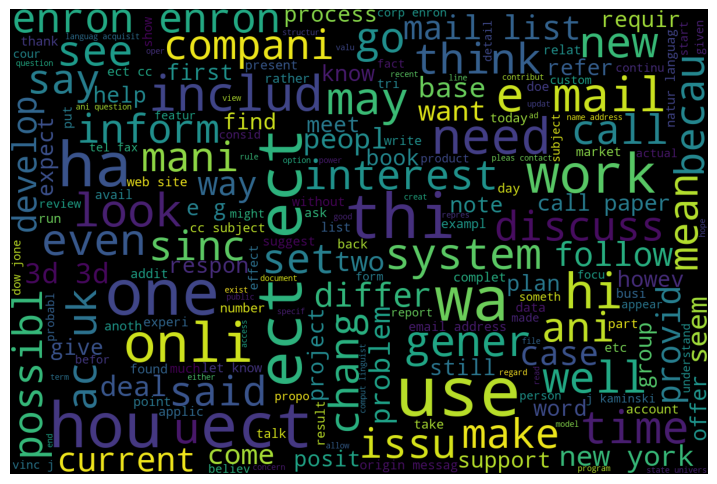

In [13]:
wc = WordCloud(width=1200, height=800, max_font_size=120, min_font_size=10, margin=2).generate(" ".join(df.cleaned_text.values[df.email_type == 'Safe Email']))
plt.figure(figsize=(9,7))
plt.imshow(wc)
plt.axis('off')
plt.show()

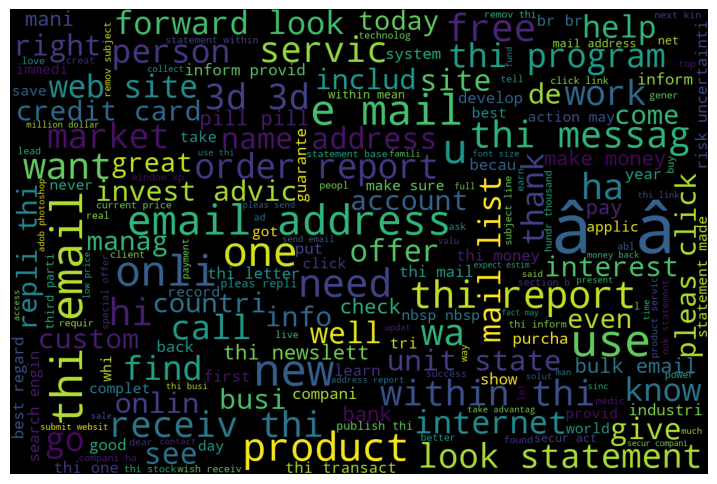

In [14]:
wc = WordCloud(width=1200, height=800, max_font_size=120, min_font_size=10, margin=2).generate(" ".join(df.cleaned_text.values[df.email_type == 'Phishing Email']))
plt.figure(figsize=(9,7))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [144]:
df['email_type']= df.email_type.apply(lambda x: 1 if x == 'Phishing Email' else 0)

In [145]:
df_backup = df

In [146]:
df['num_of_charachters'] = df.email_text.apply(lambda x: len(x))

In [147]:
df['num_of_words'] = df.email_text.apply(lambda x: len(nltk.word_tokenize(x)))

In [148]:
df['num_of_sentences'] = df.email_text.apply(lambda x: len(nltk.sent_tokenize(x)))

In [149]:
df.num_of_charachters.nlargest()

12500    17036692
11294      194978
8068       129635
15993      120761
10804      107989
Name: num_of_charachters, dtype: int64

In [20]:
df.num_of_sentences.nlargest()

12500    223247
11669      3093
9232       1511
15993      1249
2455       1209
Name: num_of_sentences, dtype: int64

In [21]:
df.num_of_words.nlargest()

12500    3623496
15993      23343
5474       20005
7375       18971
11294      18564
Name: num_of_words, dtype: int64

In [22]:
df.select_dtypes('number').describe().T

,count,mean,std,min,25%,50%,75%,max
email_type,17538.0,0.373931,0.483859,0.0,0.00,0.0,1.00,1.0
num_of_charachters,17538.0,2861.825807,128705.020233,1.0,434.25,916.0,1945.75,17036692.0
num_of_words,17538.0,586.686851,27370.203491,0.0,89.00,188.0,394.00,3623496.0
num_of_sentences,17538.0,33.465503,1686.482597,0.0,5.00,10.0,19.00,223247.0


In [39]:
df['email_type'] = df.email_type.apply(lambda x: 1 if x  == 'Phishing Email' else 0)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [108]:
Tfidf=TfidfVectorizer(lowercase=False)

In [109]:
X = df.cleaned_text.to_numpy()
y = df.email_type.to_numpy()

In [110]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=89)

## Firstly trying out Naive Bayes Algorithms as they are best for text data

In [119]:
pipe = make_pipeline(Tfidf,MultinomialNB(alpha=1.4))

In [120]:
pipe.fit(xtrain, ytrain)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(lowercase=False)),
                ('multinomialnb', MultinomialNB(alpha=1.4))])

In [121]:
y_predicted = pipe.predict(xtest)

In [122]:
print(classification_report(y_pred = y_predicted, y_true = ytest))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2167
           1       1.00      0.70      0.82      1341

    accuracy                           0.88      3508
   macro avg       0.92      0.85      0.87      3508
weighted avg       0.90      0.88      0.88      3508



In [125]:
accuracy = []
precision = []
recall = []
value = []
count = 0
for i in np.arange(0.1,21,0.1):
    pipe = make_pipeline(Tfidf,BernoulliNB(alpha=round(i,1)))
    pipe.fit(xtrain, ytrain)
    prediction = pipe.predict(xtest)
    value.append(round(i,1))
    accuracy.append(accuracy_score(prediction,ytest))
    precision.append(precision_score(prediction,ytest))
    recall.append(recall_score(prediction, ytest))
    print(round(i,1),end = '->')
bernoulli_df = pd.DataFrame({'value':value,'accuracy':accuracy,'recall':recall,'precision':precision})    
bernoulli_df    
    

0.1->0.2->0.3->0.4->0.5->0.6->0.7->0.8->0.9->1.0->1.1->1.2->1.3->1.4->1.5->1.6->1.7->1.8->1.9->2.0->2.1->2.2->2.3->2.4->2.5->2.6->2.7->2.8->2.9->3.0->3.1->3.2->3.3->3.4->3.5->3.6->3.7->3.8->3.9->4.0->4.1->4.2->4.3->4.4->4.5->4.6->4.7->4.8->4.9->5.0->5.1->5.2->5.3->5.4->5.5->5.6->5.7->5.8->5.9->6.0->6.1->6.2->6.3->6.4->6.5->6.6->6.7->6.8->6.9->7.0->7.1->7.2->7.3->7.4->7.5->7.6->7.7->7.8->7.9->8.0->8.1->8.2->8.3->8.4->8.5->8.6->8.7->8.8->8.9->9.0->9.1->9.2->9.3->9.4->9.5->9.6->9.7->9.8->9.9->10.0->10.1->10.2->10.3->10.4->10.5->10.6->10.7->10.8->10.9->11.0->11.1->11.2->11.3->11.4->11.5->11.6->11.7->11.8->11.9->12.0->12.1->12.2->12.3->12.4->12.5->12.6->12.7->12.8->12.9->13.0->13.1->13.2->13.3->13.4->13.5->13.6->13.7->13.8->13.9->14.0->14.1->14.2->14.3->14.4->14.5->14.6->14.7->14.8->14.9->15.0->15.1->15.2->15.3->15.4->15.5->15.6->15.7->15.8->15.9->16.0->16.1->16.2->16.3->16.4->16.5->16.6->16.7->16.8->16.9->17.0->17.1->17.2->17.3->17.4->17.5->17.6->17.7->17.8->17.9->18.0->18.1->18.2->18.3->1

,value,accuracy,recall,precision
0,0.1,0.932155,0.862114,0.979120
1,0.2,0.934436,0.864741,0.982103
2,0.3,0.937571,0.870542,0.982849
3,0.4,0.940707,0.877415,0.982103
4,0.5,0.946123,0.891304,0.978374
...,...,...,...,...
204,20.5,0.626853,1.000000,0.023863
205,20.6,0.626568,1.000000,0.023117
206,20.7,0.626568,1.000000,0.023117
207,20.8,0.626568,1.000000,0.023117


In [131]:
bernoulli_df['mean'] = (bernoulli_df.accuracy+bernoulli_df.recall+bernoulli_df.precision)/3

In [133]:
bernoulli_df.sort_values(by = 'mean', ascending=False)

,value,accuracy,recall,precision,mean
10,1.1,0.967788,0.960961,0.954512,0.961087
11,1.2,0.967503,0.970115,0.944072,0.960563
12,1.3,0.965792,0.976581,0.932886,0.958420
9,1.0,0.963797,0.941776,0.964952,0.956841
13,1.4,0.963227,0.981717,0.920955,0.955299
...,...,...,...,...,...
204,20.5,0.626853,1.000000,0.023863,0.550239
205,20.6,0.626568,1.000000,0.023117,0.549895
206,20.7,0.626568,1.000000,0.023117,0.549895
207,20.8,0.626568,1.000000,0.023117,0.549895


In [127]:
multinomial_df['mean'] =( multinomial_df.accuracy+multinomial_df.recall+multinomial_df.precision)/3

In [130]:
multinomial_df.sort_values(by = 'mean', ascending=False)

,value,accuracy,recall,precision,mean
0,0.1,0.967788,0.979688,0.935123,0.960866
1,0.2,0.962087,0.987097,0.912752,0.953978
2,0.3,0.954675,0.990050,0.890380,0.945035
3,0.4,0.947834,0.989848,0.872483,0.936721
4,0.5,0.937571,0.992105,0.843400,0.924359
...,...,...,...,...,...
204,20.5,0.709236,1.000000,0.239374,0.649537
205,20.6,0.708666,1.000000,0.237882,0.648849
206,20.7,0.708666,1.000000,0.237882,0.648849
207,20.8,0.708381,1.000000,0.237136,0.648506


## Trying out Other Algorithms Too

In [152]:
xtrain_transformed = Tfidf.transform(xtrain)
xtest_transformed = Tfidf.transform(xtest)

## Multinomial

In [43]:
model = MultinomialNB()
model.fit(xtrain_transformed.toarray(), ytrain)

MultinomialNB()

In [44]:
y_pred = mlb.predict(xtest_transformed)

In [45]:
print(classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2063
           1       0.97      0.90      0.93      1445

    accuracy                           0.94      3508
   macro avg       0.95      0.94      0.94      3508
weighted avg       0.95      0.94      0.94      3508



In [232]:
print(confusion_matrix(y_pred, ytest))

[[2017   46]
 [ 150 1295]]


## Gaussian

In [47]:
gnb = GaussianNB()

In [49]:
gnb.fit(xtrain_transformed.toarray(), ytrain)

GaussianNB()

In [51]:
y_predd = gnb.predict(xtest_transformed.toarray())

In [53]:
print(classification_report(y_predd, ytest))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2046
           1       0.87      0.80      0.83      1462

    accuracy                           0.87      3508
   macro avg       0.87      0.86      0.86      3508
weighted avg       0.87      0.87      0.87      3508



## Bernoulli

In [234]:
bnl = BernoulliNB()

In [235]:
bnl.fit(xtrain_transformed.toarray(), ytrain)

BernoulliNB()

In [236]:
y_preddd = bnl.predict(xtest_transformed.toarray())

In [237]:
print(classification_report(y_preddd, ytest))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2134
           1       0.96      0.94      0.95      1374

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



In [239]:
print(confusion_matrix(y_preddd, ytest))

[[2087   47]
 [  80 1294]]


In [243]:
from sklearn.metrics import accuracy_score, recall_score
print(accuracy_score(y_preddd, ytest))
print(recall_score(y_preddd, ytest))

0.9637970353477765
0.9417758369723436


## KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
knn = KNeighborsClassifier()

In [63]:
knn.fit(xtrain_transformed, ytrain)

KNeighborsClassifier()

In [64]:
y_predddd = knn.predict(xtest_transformed)

In [65]:
print(classification_report(y_predddd, ytest))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2418
           1       0.67      0.83      0.74      1090

    accuracy                           0.82      3508
   macro avg       0.79      0.82      0.80      3508
weighted avg       0.84      0.82      0.82      3508



## SVC

In [66]:
from sklearn.svm import SVC

In [67]:
svc = SVC()

In [69]:
svc.fit(xtrain_transformed, ytrain)

SVC()

In [70]:
y_predddd = svc.predict(xtest_transformed)

In [71]:
print(classification_report(y_predddd, ytest))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2527
           1       0.71      0.97      0.82       981

    accuracy                           0.88      3508
   macro avg       0.85      0.91      0.86      3508
weighted avg       0.91      0.88      0.88      3508



## LogisticRegression

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
lr = LogisticRegression()

In [74]:
lr.fit(xtrain_transformed, ytrain)

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [75]:
y_preddddd = lr.predict(xtest_transformed)

In [76]:
print(classification_report(y_preddddd, ytest))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2202
           1       0.94      0.96      0.95      1306

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



## SGDClassifier

In [86]:
from sklearn.linear_model import SGDClassifier

In [87]:
GDC = SGDClassifier()

In [88]:
GDC.fit(xtrain_transformed, ytrain)

SGDClassifier()

In [89]:
y_predddddd = GDC.predict(xtest_transformed)

In [187]:
print(classification_report(y_predddddd, ytest))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2210
           1       0.93      0.96      0.95      1298

    accuracy                           0.96      3508
   macro avg       0.95      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



## ExtraTreesClassifier

In [92]:
from sklearn.ensemble import ExtraTreesClassifier

In [195]:
etc = ExtraTreesClassifier()

In [196]:
etc.fit(xtrain_transformed, ytrain)

ExtraTreesClassifier()

In [197]:
y_preddddddd = etc.predict(xtest_transformed)

In [198]:
print(classification_report(y_preddddddd, ytest))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2282
           1       0.90      0.99      0.94      1226

    accuracy                           0.96      3508
   macro avg       0.95      0.96      0.95      3508
weighted avg       0.96      0.96      0.96      3508



## GradienBoostClassifier

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

In [99]:
GBC = GradientBoostingClassifier()

In [100]:
GBC.fit(xtrain_transformed, ytrain)

GradientBoostingClassifier()

In [102]:
y_predddddddd =  GBC.predict(xtest_transformed)

In [103]:
print(classification_report(y_predddddddd, ytest))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2395
           1       0.79      0.96      0.87      1113

    accuracy                           0.91      3508
   macro avg       0.88      0.92      0.90      3508
weighted avg       0.92      0.91      0.91      3508



## AdaBoostClassifier

In [104]:
from sklearn.ensemble import AdaBoostClassifier

In [105]:
adc=AdaBoostClassifier()

In [106]:
adc.fit(xtrain_transformed, ytrain)

AdaBoostClassifier()

In [107]:
y_preddddddddd = adc.predict(xtest_transformed)

In [108]:
print(classification_report(y_preddddddddd, ytest))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2338
           1       0.80      0.92      0.86      1170

    accuracy                           0.90      3508
   macro avg       0.88      0.90      0.89      3508
weighted avg       0.91      0.90      0.90      3508



## ExtremeGradientBoostClassifier

In [109]:
from xgboost.sklearn import XGBClassifier

In [110]:
XGB = XGBClassifier()

In [111]:
XGB.fit(xtrain_transformed, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [112]:
y_predddddddddd = XGB.predict(xtest_transformed)

In [113]:
print(classification_report(y_predddddddddd, ytest))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2226
           1       0.92      0.96      0.94      1282

    accuracy                           0.95      3508
   macro avg       0.95      0.95      0.95      3508
weighted avg       0.95      0.95      0.95      3508



## LogisticRegression With Bagging

In [114]:
from sklearn.ensemble import BaggingClassifier

In [116]:
baglr = BaggingClassifier(LogisticRegression())

In [117]:
baglr.fit(xtrain_transformed, ytrain)

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

BaggingClassifier(estimator=LogisticRegression())

In [119]:
y_preddddddddddd = baglr.predict(xtest_transformed)

In [120]:
print(classification_report(y_preddddddddddd, ytest))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2198
           1       0.93      0.96      0.94      1310

    accuracy                           0.96      3508
   macro avg       0.95      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



### FInding best pramas for bernoulliNB

In [380]:
params = {
    'alpha' : [0.001,0.1,1,2,3,5,7,10],
    'force_alpha' : [True, False],
    'fit_prior' : [True, False],
}

In [245]:
search = GridSearchCV(BernoulliNB(),scoring='recall',param_grid=params)

In [246]:
search.fit(xtrain_transformed, ytrain)

GridSearchCV(estimator=BernoulliNB(),
             param_grid={'alpha': [0.001, 0.1, 1, 2, 3, 5, 7, 10],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='recall')

In [247]:
search.best_estimator_

BernoulliNB(alpha=0.1, fit_prior=False, force_alpha=True)

In [370]:
bestalgo = BernoulliNB(alpha=1.1, fit_prior=True, force_alpha=False)

In [371]:
bestalgo.fit(xtrain_transformed, ytrain)

BernoulliNB(alpha=1.1, force_alpha=False)

In [372]:
print(classification_report(y_pred = bestalgo.predict(xtest_transformed),y_true=ytest))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2167
           1       0.96      0.95      0.96      1341

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



In [373]:
print(confusion_matrix(y_pred = bestalgo.predict(xtest_transformed),y_true=ytest)[0][1])
print(confusion_matrix(y_pred = bestalgo.predict(xtest_transformed),y_true=ytest)[1][0])

52
61


In [379]:
print(accuracy_score(y_pred = bestalgo.predict(xtest_transformed),y_true=ytest))
print(recall_score(y_pred = bestalgo.predict(xtest_transformed),y_true=ytest))
from sklearn.model_selection import cross_val_score
cross_val_score(BernoulliNB(alpha=1.1, fit_prior=True),cv = 10, scoring='recall',X=xtrain_transformed, y = ytrain).mean()

0.9677879133409351
0.9545115585384042


0.9536115339643038

In [347]:
cm_list = []
for i in np.arange(0.1,11,.1):
    cm = confusion_matrix(BernoulliNB(alpha=i, fit_prior=True, force_alpha=False).fit(xtrain_transformed, ytrain).predict(xtest_transformed),ytest)
    full = cm[0][1] + cm[1][0]
    cm_list.append(full)

In [351]:
pd.DataFrame({"alpha_value":np.arange(0.1,11,.1),'cm_sum':cm_list}).sort_values(by = 'cm_sum')

,alpha_value,cm_sum
10,1.1,113
11,1.2,114
12,1.3,120
9,1.0,127
13,1.4,129
...,...,...
104,10.5,1216
105,10.6,1218
106,10.7,1219
107,10.8,1219


## Now that we have found best params we are gonna dump this

In [136]:
import pickle

In [134]:
pipe = make_pipeline(TfidfVectorizer(),BernoulliNB(alpha=1.1))

In [135]:
pipe.fit(xtrain, ytrain)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('bernoullinb', BernoulliNB(alpha=1.1))])

In [137]:
pickle.dump(pipe, open('Bernoulli_model_for_email.pkl','wb'))